In [2]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
sns.set(rc={'figure.figsize':(6,8)}) 

import warnings
warnings.simplefilter("ignore")

%matplotlib inline

from sklearn.preprocessing import LabelEncoder 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn import metrics

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import SCORERS
import re

import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
data = pd.read_csv('data_privacy_tweets.csv')

pd.set_option('display.max_colwidth', -1)
data = data.drop_duplicates('text')
data.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,statuses_count,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url
0,x1166589525386301440,x1404485195676459008,2021-06-14 17:05:39,privacy_issues,The @EFF finds that the proposed modifications...,TweetDeck,248,NaN,NaN,NaN,...,1036,2177,2019-08-28 05:53:33,False,https://t.co/HFMGW8U18M,http://bit.ly/privacyissuessignup,NaN,https://pbs.twimg.com/profile_banners/11665895...,NaN,http://pbs.twimg.com/profile_images/1166589644...
1,x1166589525386301440,x1403010409473449986,2021-06-10 15:25:22,privacy_issues,The European Parliament passes the new #EU #CO...,TweetDeck,223,NaN,NaN,NaN,...,1036,2177,2019-08-28 05:53:33,False,https://t.co/HFMGW8U18M,http://bit.ly/privacyissuessignup,NaN,https://pbs.twimg.com/profile_banners/11665895...,NaN,http://pbs.twimg.com/profile_images/1166589644...
2,x1166589525386301440,x1404185087093182465,2021-06-13 21:13:07,privacy_issues,To gain better control over the increasingly p...,TweetDeck,240,NaN,NaN,NaN,...,1036,2177,2019-08-28 05:53:33,False,https://t.co/HFMGW8U18M,http://bit.ly/privacyissuessignup,NaN,https://pbs.twimg.com/profile_banners/11665895...,NaN,http://pbs.twimg.com/profile_images/1166589644...
3,x1166589525386301440,x1401833811940306947,2021-06-07 09:30:00,privacy_issues,What if the consumers are on the driving seat ...,TweetDeck,255,NaN,NaN,NaN,...,1036,2177,2019-08-28 05:53:33,False,https://t.co/HFMGW8U18M,http://bit.ly/privacyissuessignup,NaN,https://pbs.twimg.com/profile_banners/11665895...,NaN,http://pbs.twimg.com/profile_images/1166589644...
4,x1166589525386301440,x1401555697163280387,2021-06-06 15:04:52,privacy_issues,"""Vera Jourová says new rules are needed to lim...",TweetDeck,230,NaN,NaN,NaN,...,1036,2177,2019-08-28 05:53:33,False,https://t.co/HFMGW8U18M,http://bit.ly/privacyissuessignup,NaN,https://pbs.twimg.com/profile_banners/11665895...,NaN,http://pbs.twimg.com/profile_images/1166589644...


In [4]:
df = data[["text", "is_quote", "is_retweet", "retweet_count", "hashtags", "followers_count"]]
df.shape

(10637, 6)

In [5]:
df['text'].head()

0    The @EFF finds that the proposed modifications...
1    The European Parliament passes the new #EU #CO...
2    To gain better control over the increasingly p...
3    What if the consumers are on the driving seat ...
4    "Vera Jourová says new rules are needed to lim...
Name: text, dtype: object

In [6]:
text = df[["text"]][:10000]
text.head()

,text
0,The @EFF finds that the proposed modifications...
1,The European Parliament passes the new #EU #CO...
2,To gain better control over the increasingly p...
3,What if the consumers are on the driving seat ...
4,"""Vera Jourová says new rules are needed to lim..."


# Data cleaning

In [7]:
wnet = WordNetLemmatizer()
port = PorterStemmer()

In [13]:
def cleanTxt(txt):
    txt = txt.lower()
    txt = re.sub(r'RT[\s]+', '', txt) #removing RT
    txt = re.sub(r'[^\w\s]','', txt) #remove everything except words and space
    txt = re.sub(r'_','', txt) #how to remove underscore as well
    txt = re.sub('\r\n', '', txt)
    if 'https' in txt: # removing hyperlinks 
        pos = txt.find('https')
        txt = txt[:pos]
    return txt

In [19]:
text['text'] = text['text'].apply(cleanTxt)
text.head()
# question: also remove hashtags, @'s?'

,text
0,eff find proposed modification hipaa would invade personal intimiate health data stating trust healthcare crucial especially covid pandemicread
1,european parliament pa new eu covid19 certificate regulation detailing people covid informationpromising personal data processed line gdprread
2,gain better control increasingly powerful technology sector china new regulation china make harder big tech refuse government request datasharing datasecurityread
3,consumer driving seat agree disagree privacypolicy tech giant article beth magnusonexplains dataprivacy amp innovation venturebeat
4,vera jourová say new rule needed limit bulk collection european datathe eu requiring new legislation limiting u government agency accessing european data read


In [15]:
def stopWords(txt): 
    txt_lst = txt.split(" ")
    txt_lst = [word for word in txt_lst if word not in stopwords.words('english')]
    txt_lst = [wnet.lemmatize(word) for word in txt_lst]
    txt_lst = [word for word in txt_lst if word != '']
    txt_lst = [word for word in txt_lst if word != '\r\n\r\n'] # indicates space and indexing
    txt_lst = [word for word in txt_lst if word != 'u0001f449'] # indicates back hand emoji pointing right
    txt_lst = [word for word in txt_lst if word != 'cybersecurity']
    txt_lst = [word for word in txt_lst if word != 'cyber']
    txt_lst = [word for word in txt_lst if word != 'security']
    return " ".join(txt_lst)

In [18]:

text['text'] = text['text'].apply(stopWords)
text.head()

,text
0,eff find proposed modification hipaa would invade personal intimiate health data stating trust healthcare crucial especially covid pandemicread
1,european parliament pa new eu covid19 certificate regulation detailing people covid informationpromising personal data processed line gdprread
2,gain better control increasingly powerful technology sector china new regulation china make harder big tech refuse government request datasharing datasecurityread
3,consumer driving seat agree disagree privacypolicy tech giant article beth magnusonexplains dataprivacy amp innovation venturebeat
4,vera jourová say new rule needed limit bulk collection european datathe eu requiring new legislation limiting u government agency accessing european data read


# Vectorizing Data

Vectorizing using Binary Term Frequency (https://towardsdatascience.com/getting-started-with-text-vectorization-2f2efbec6685). Binary Term Frequency captures presence (1) or absence (0) of term in document. For this part, under TfidfVectorizer, we set binary parameter equal to true so that it can show just presence (1) or absence (0) and norm parameter equal to false.

In [17]:
text_lst = []
for row in text['text']:
    text_lst.append(row)

text_lst[:5] # need to make into a list so the vectorizer will work

['eff find proposed modification hipaa would invade personal intimiate health data stating trust healthcare crucial especially covid pandemicread',
 'european parliament pas new eu covid19 certificate regulation detailing people covid informationpromising personal data processed line gdprread',
 'gain better control increasingly powerful technology sector china new regulation china make harder big tech refuse government request datasharing datasecurityread',
 'consumer driving seat agree disagree privacypolicy tech giant article beth magnusonexplains dataprivacy amp innovation venturebeat',
 'vera jourová say new rule needed limit bulk collection european datathe eu requiring new legislation limiting u government agency accessing european data read']

In [20]:
def stopWords(txt): 
    txt_lst = txt.split(" ")
    txt_lst = [word for word in txt_lst if word not in stopwords.words('english')]
    txt_lst = [wnet.lemmatize(word) for word in txt_lst]
    txt_lst = [word for word in txt_lst if word != '']
    txt_lst = [word for word in txt_lst if word != '\r\n\r\n'] # indicates space and indexing
    txt_lst = [word for word in txt_lst if word != 'u0001f449'] # indicates back hand emoji pointing right
    txt_lst = [word for word in txt_lst if word != 'cybersecurity']
    txt_lst = [word for word in txt_lst if word != 'cyber']
    txt_lst = [word for word in txt_lst if word != 'security']
    return " ".join(txt_lst)

In [21]:
tv = TfidfVectorizer(
binary = True, norm = None,
use_idf = False, smooth_idf = False,
lowercase = True, stop_words = None,
min_df = 1, max_df = 1.0, max_features = None, ngram_range = (1,1))

In [22]:
text_vec = pd.DataFrame(tv.fit_transform(text_lst).toarray(), columns = tv.get_feature_names())
text_vec.head()

,0001860173,007cybersecurity,01,010,0100,020,05,050,06,0613you,...,zoomecertificates,zoominfo,zootokenio,zscaler,zuboff,zuck,zuckerberg,zumbullaw,zunit14,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# List of Words

In [24]:
cs_words = []

for row in text['text']:
    for word in str(row).split(" "):
        cs_words.append(word)

In [26]:
from nltk.probability import FreqDist
fdist = FreqDist() # what is FreqDist()?
for word in cs_words:
    fdist[word]+=1
fdist

FreqDist({'data': 9591, 'privacy': 7808, 'u': 1150, 'new': 1138, 'apple': 1069, 'amp': 934, 'user': 873, 'protection': 657, 'policy': 625, 'company': 620, ...})

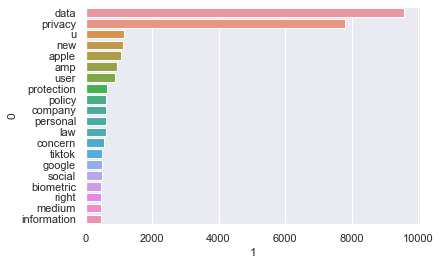

In [28]:
freq_data = pd.DataFrame.from_dict(fdist.most_common(20))
sns.barplot(data = freq_data, x = 1, y = 0);

In [32]:
most_common = []

for key in fdist.most_common(20):
    most_common.append(key[0])
    
most_common

['data',
 'privacy',
 'u',
 'new',
 'apple',
 'amp',
 'user',
 'protection',
 'policy',
 'company',
 'personal',
 'law',
 'concern',
 'tiktok',
 'google',
 'social',
 'biometric',
 'right',
 'medium',
 'information']

# Clustering

In [30]:
def evaluate_k_kmeans_inertia(k):
    print(f"running Kmeans with k={k}")
    estimator_kmeans = KMeans(random_state=42, n_clusters=k)
    estimator_kmeans.fit(text_vec)
    return estimator_kmeans.inertia_

In [33]:
%%time 
range_k = [i for i in range(1, 9)]
results_k = {}
for k in range_k:
    results_k[k] = evaluate_k_kmeans_inertia(k)

running Kmeans with k=1
running Kmeans with k=2
running Kmeans with k=3
running Kmeans with k=4
running Kmeans with k=5
running Kmeans with k=6
running Kmeans with k=7
running Kmeans with k=8
CPU times: user 14min 59s, sys: 1min 37s, total: 16min 36s
Wall time: 4min 46s


In [34]:
results_k

{1: 144725.1328999987,
 2: 141244.38656598516,
 3: 138912.63370099795,
 4: 139585.97477912414,
 5: 138775.81022659436,
 6: 137919.69123132373,
 7: 136988.49083179949,
 8: 135747.86426202446}

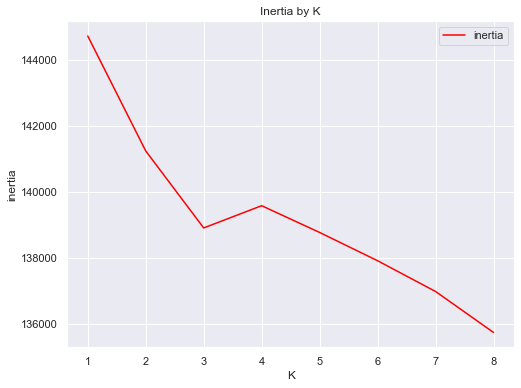

In [41]:
# we can now plot this to see where the inflection point is or where adding more clusters doesnt really add to gaining
# more information from extra clusters

fig, ax = plt.subplots(figsize=(8,6))
ax = sns.lineplot(
    [c[0] for c in results_k.items()],
    [c[1] for c in results_k.items()], label="inertia", color="red")
ax.set_xlabel("K")
ax.set_ylabel("inertia")
ax.set_title("Inertia by K")
ax.legend();
# this is a very strange plot.

## Cluster Analysis

In [42]:
estimator_kmeans = KMeans(random_state=42, n_clusters=4) # making it 7 now to see what happens

estimator_kmeans.fit(text_vec) # fit the model to our vehicles data

KMeans(n_clusters=4, random_state=42)

In [43]:
text_vec["cluster_id"] = estimator_kmeans.labels_
text_vec.head()

,0001860173,007cybersecurity,01,010,0100,020,05,050,06,0613you,...,zoominfo,zootokenio,zscaler,zuboff,zuck,zuckerberg,zumbullaw,zunit14,zurich,cluster_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [44]:
text_clusters = text_vec.groupby('cluster_id').sum()
text_clusters.head()

,0001860173,007cybersecurity,01,010,0100,020,05,050,06,0613you,...,zoomecertificates,zoominfo,zootokenio,zscaler,zuboff,zuck,zuckerberg,zumbullaw,zunit14,zurich
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,1.0,1.0,5.0,0.0,0.0,0.0
1,1.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,5.0,6.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
text_clusters_20 = text_clusters[['data',
 'privacy',
 'new',
 'apple',
 'amp',
 'user',
 'protection',
 'policy',
 'company',
 'personal',
 'law',
 'concern',
 'tiktok',
 'google',
 'social',
 'biometric',
 'right',
 'medium',
 'information']
]

text_clusters_20.head() 

,data,privacy,new,apple,amp,user,protection,policy,company,personal,law,concern,tiktok,google,social,biometric,right,medium,information
cluster_id,,,,,,,,,,,,,,,,,,,
0,1590.0,55.0,339.0,171.0,136.0,144.0,85.0,22.0,141.0,133.0,21.0,29.0,26.0,162.0,24.0,20.0,58.0,24.0,92.0
1,5452.0,6110.0,540.0,715.0,522.0,602.0,446.0,560.0,383.0,405.0,2.0,224.0,310.0,236.0,123.0,272.0,303.0,102.0,270.0
2,961.0,970.0,112.0,19.0,66.0,31.0,103.0,26.0,53.0,45.0,525.0,296.0,7.0,19.0,321.0,19.0,44.0,321.0,48.0
3,42.0,51.0,0.0,2.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,6.0,2.0,2.0,0.0,2.0,3.0


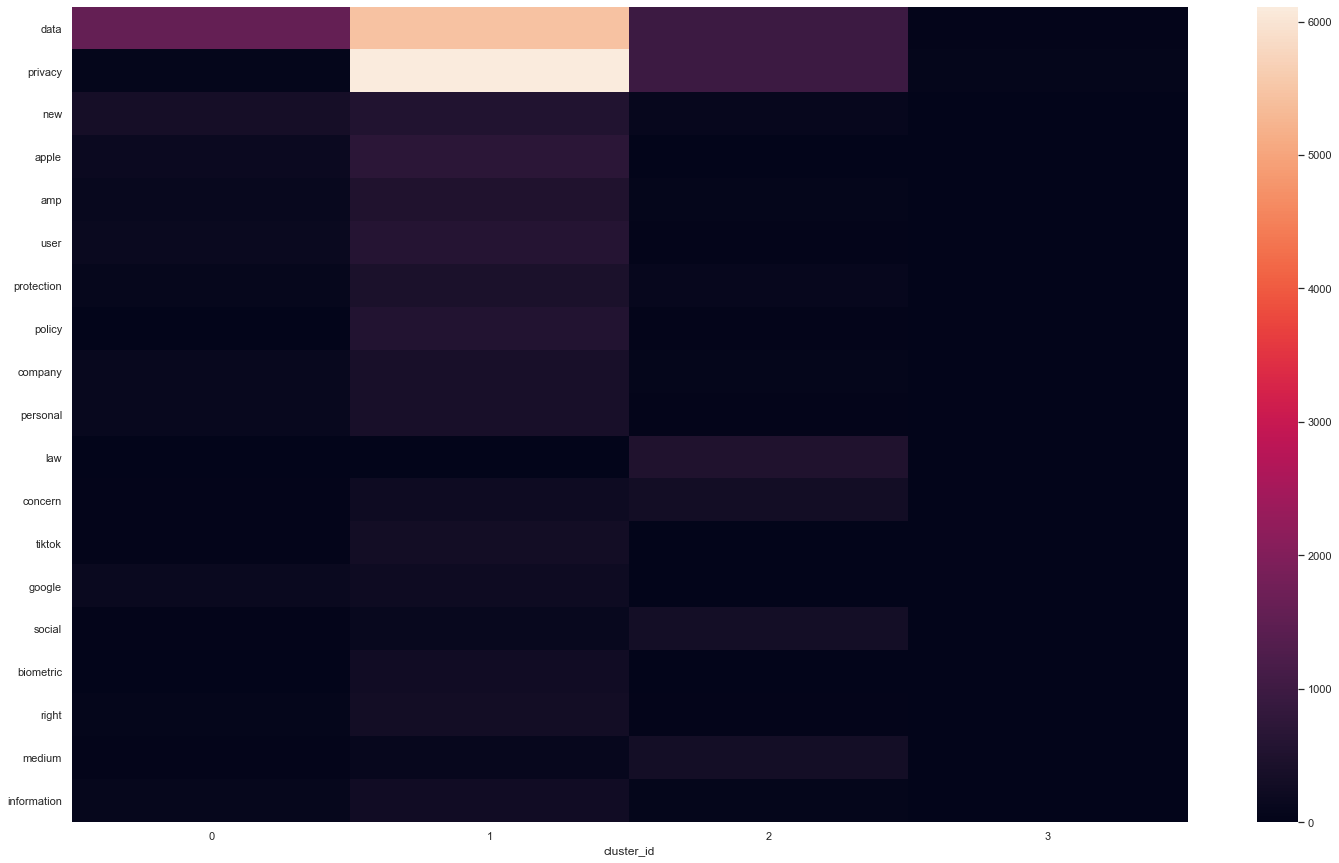

In [46]:
fig, ax = plt.subplots(figsize=(25,15))
sns.heatmap(text_clusters_20.transpose(), annot=False);
# Look for rows with a lot of variation to see defining features